# Air Quality

Predicting air quality with Prophet
Feature description [here](https://www.kaggle.com/sayakchakraborty/air-quality-prediction-of-relative-humidity)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

## Import dataset

In [2]:
DATAPATH = 'P:/Data Science/Air Quality Prediction/data/AirQualityUCI.csv'

data = pd.read_csv(DATAPATH, sep=';')
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [3]:
data.shape

(9471, 17)

In [4]:
data.dropna(axis=1, how='all', inplace=True)
data.dropna(axis=0, how='all', inplace=True)

In [5]:
data.shape

(9357, 15)

In [6]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


## Data cleaning and feature engineering

In [7]:
data['Date'] = pd.to_datetime(data['Date'])

In [8]:
## converting columns to float and also replacing ',' to '.'
for col in data.iloc[:,2:].columns:
    if data[col].dtypes == object:
        data[col] = data[col].str.replace(',','.').astype('float')

In [9]:
#removing negative values 
def positive_average(num):
    return num[num > -200].mean()
#aggregating data by day   
daily_data = data.drop('Time', axis=1).groupby('Date').apply(positive_average)

In [10]:
daily_data.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,,,,,
2004-01-04,2.550000,1244.380952,310.125,11.971429,1010.428571,161.304348,880.666667,96.739130,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-05,2.056522,1097.500000,275.000,8.662500,913.708333,104.739130,918.083333,84.956522,1640.416667,904.625000,20.150000,52.183333,1.167313
2004-01-06,2.100000,1135.583333,NaN,12.375000,1021.875000,152.043478,896.791667,75.869565,1881.500000,1066.958333,20.325000,66.154167,1.533350
2004-01-07,2.162500,1130.583333,NaN,12.225000,1038.541667,139.695652,740.916667,113.434783,1854.250000,1059.625000,30.450000,39.691667,1.624108
2004-01-08,0.983333,974.166667,NaN,5.808333,792.583333,51.739130,880.083333,58.521739,1559.000000,670.583333,30.654167,42.120833,1.673521


In [11]:
daily_data.isna().sum() > 8

CO(GT)            True
PT08.S1(CO)      False
NMHC(GT)          True
C6H6(GT)         False
PT08.S2(NMHC)    False
NOx(GT)           True
PT08.S3(NOx)     False
NO2(GT)           True
PT08.S4(NO2)     False
PT08.S5(O3)      False
T                False
RH               False
AH               False
dtype: bool

In [12]:
#removing columns which have null values above 8
daily_data = daily_data.iloc[:,(daily_data.isna().sum() <= 8).values]

In [13]:
daily_data.head()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,
2004-01-04,1244.380952,11.971429,1010.428571,880.666667,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-05,1097.500000,8.662500,913.708333,918.083333,1640.416667,904.625000,20.150000,52.183333,1.167313
2004-01-06,1135.583333,12.375000,1021.875000,896.791667,1881.500000,1066.958333,20.325000,66.154167,1.533350
2004-01-07,1130.583333,12.225000,1038.541667,740.916667,1854.250000,1059.625000,30.450000,39.691667,1.624108
2004-01-08,974.166667,5.808333,792.583333,880.083333,1559.000000,670.583333,30.654167,42.120833,1.673521


In [14]:
daily_data.shape

(391, 9)

In [15]:
daily_data = daily_data.dropna()

In [16]:
daily_data.shape

(383, 9)

In [17]:
#aggregating data by week to get a smoother trend
weekly_data = daily_data.resample('W').mean()

In [18]:
weekly_data.head()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,
2004-01-04,1244.380952,11.971429,1010.428571,880.666667,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-11,1136.801760,11.674457,1009.344462,760.484990,1727.833075,1083.683747,24.564726,53.224017,1.526858
2004-01-18,1173.375000,13.429167,1050.458333,1490.333333,1448.541667,1196.333333,10.891667,77.000000,1.002796
2004-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
weekly_data = weekly_data.dropna()

In [20]:
weekly_data.shape

(73, 9)

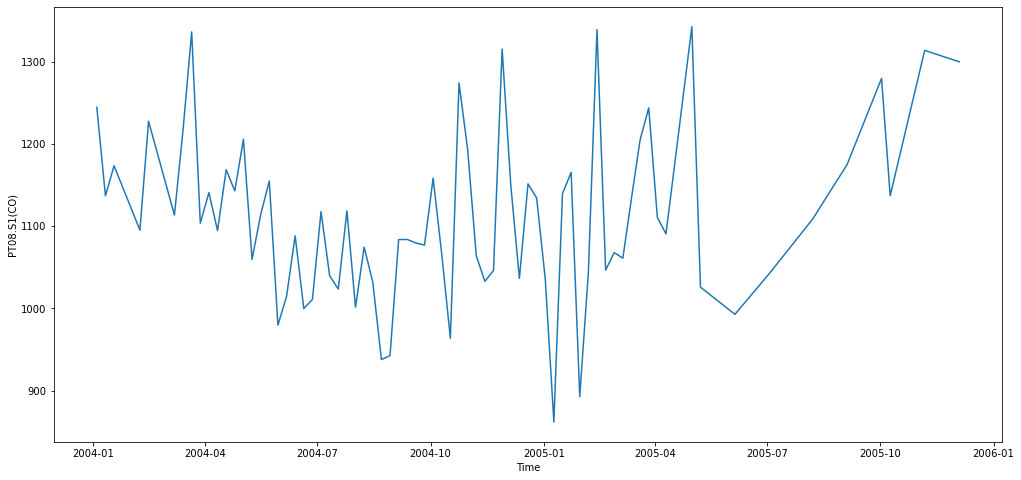

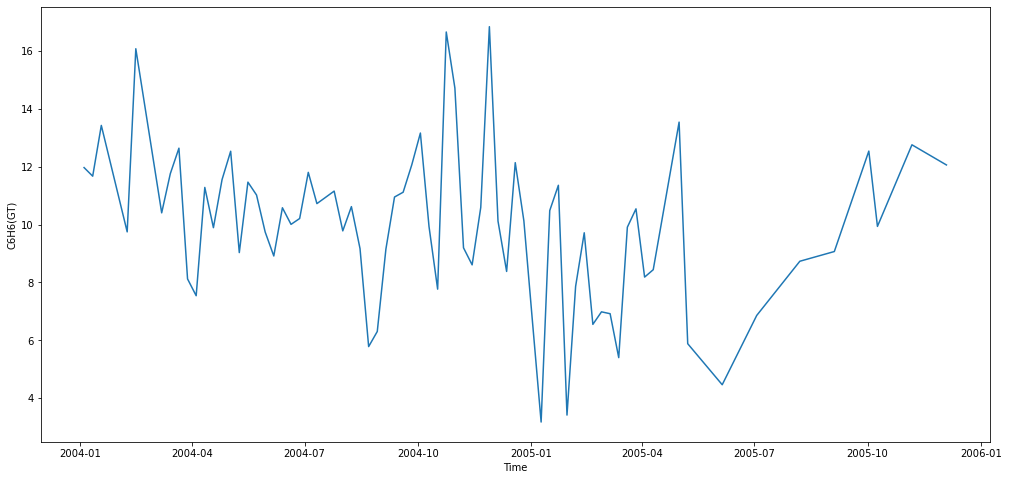

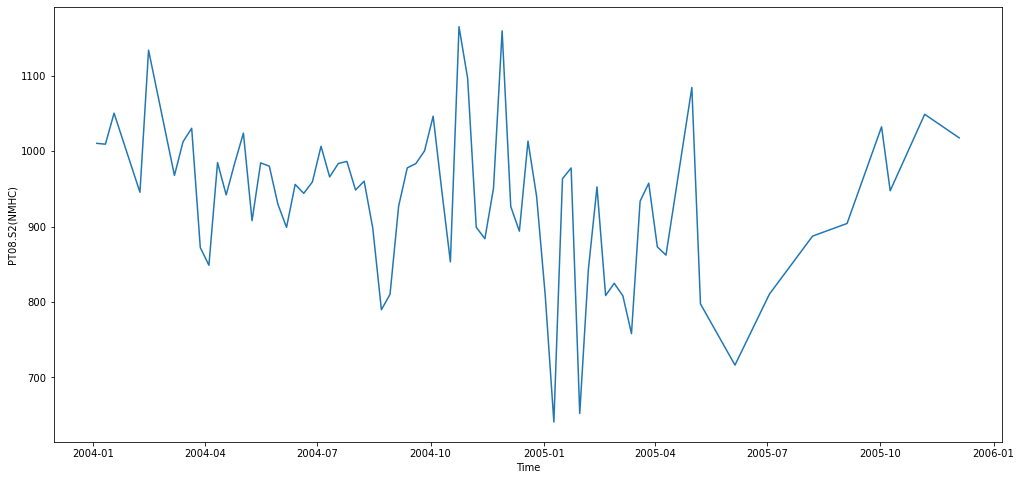

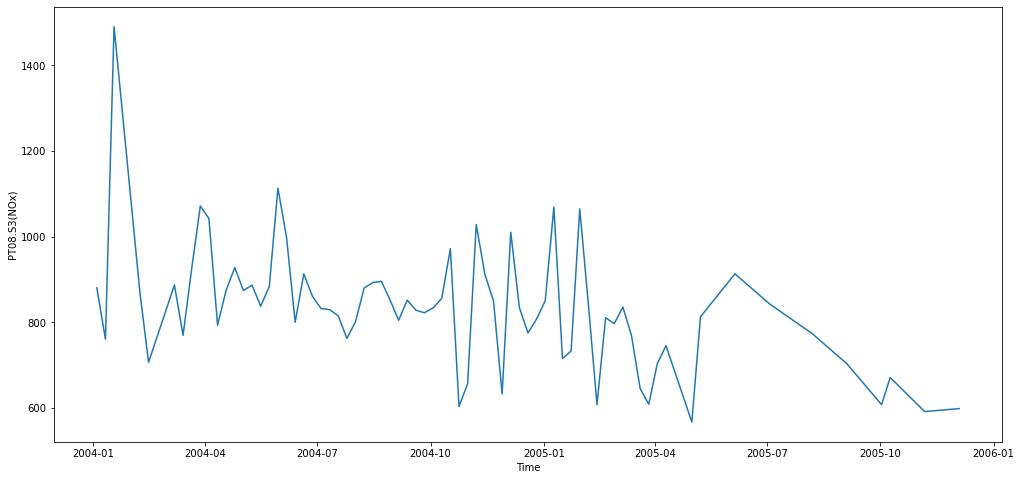

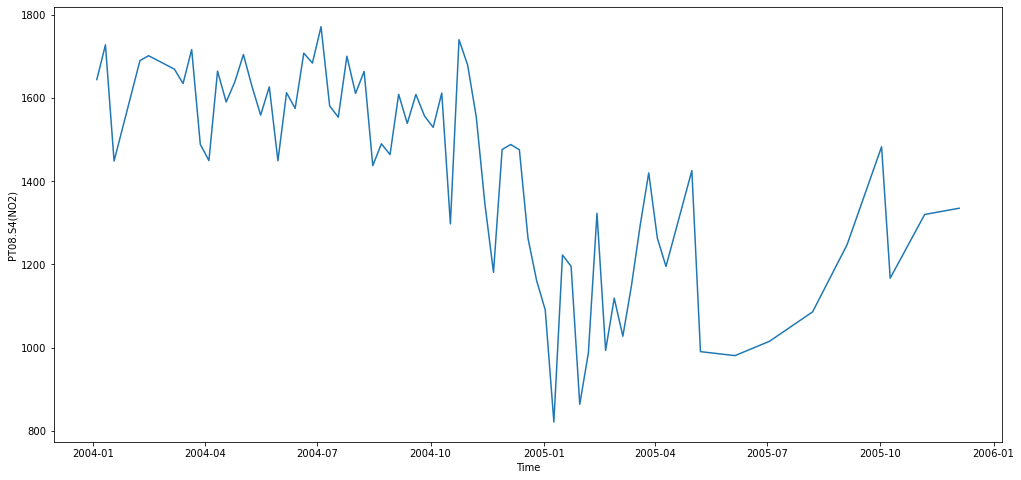

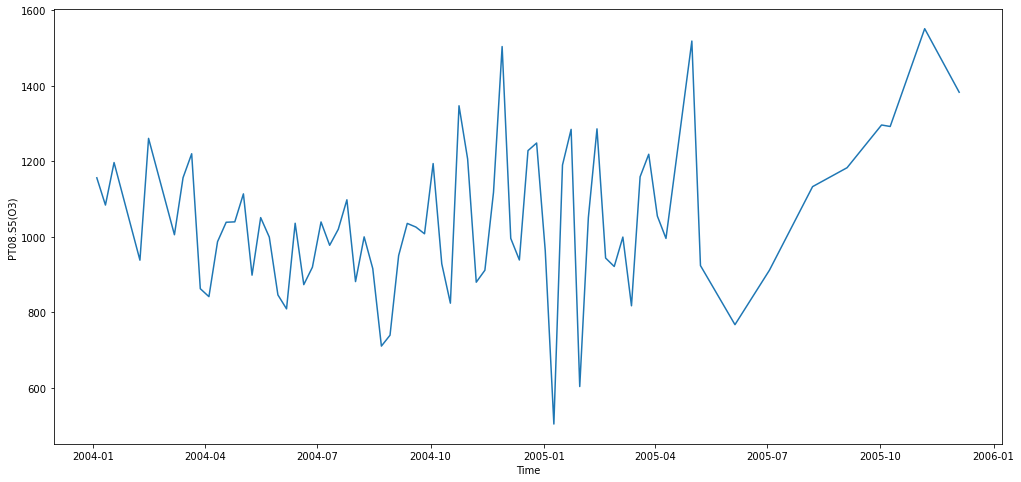

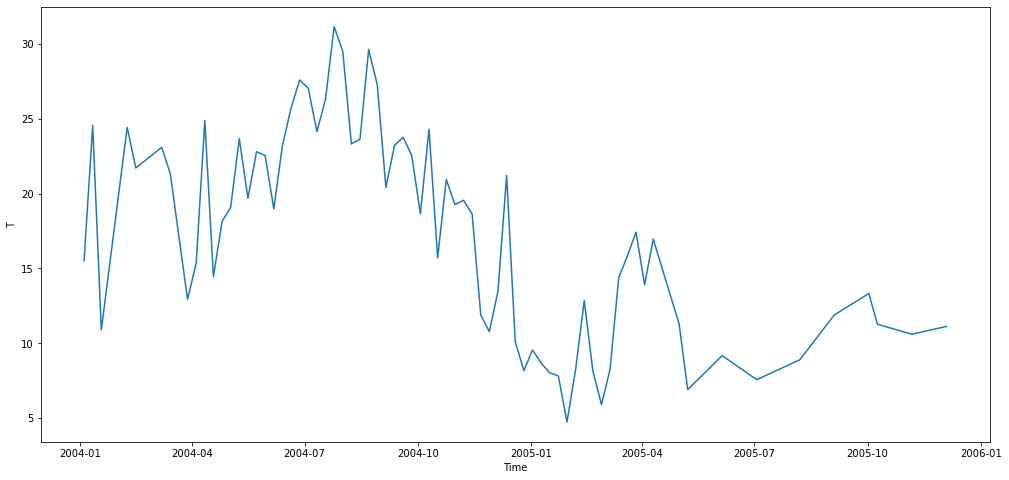

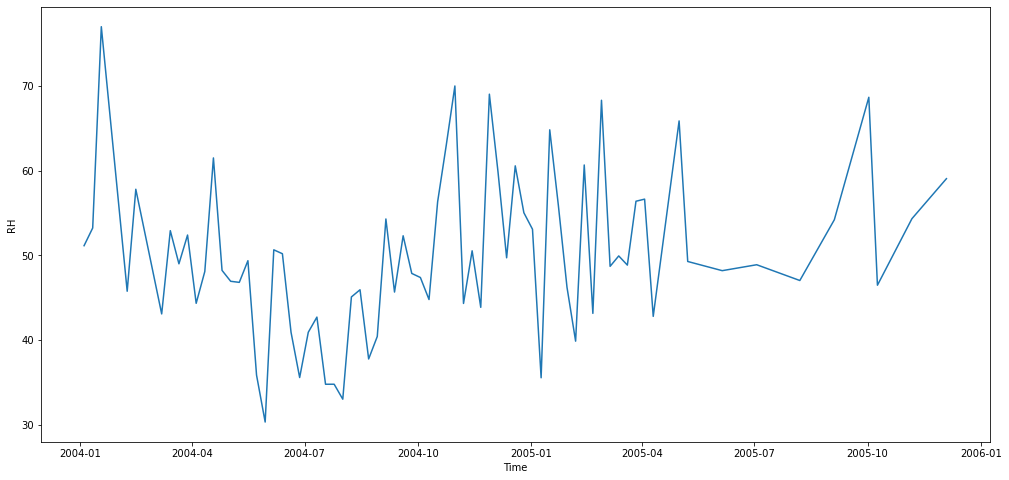

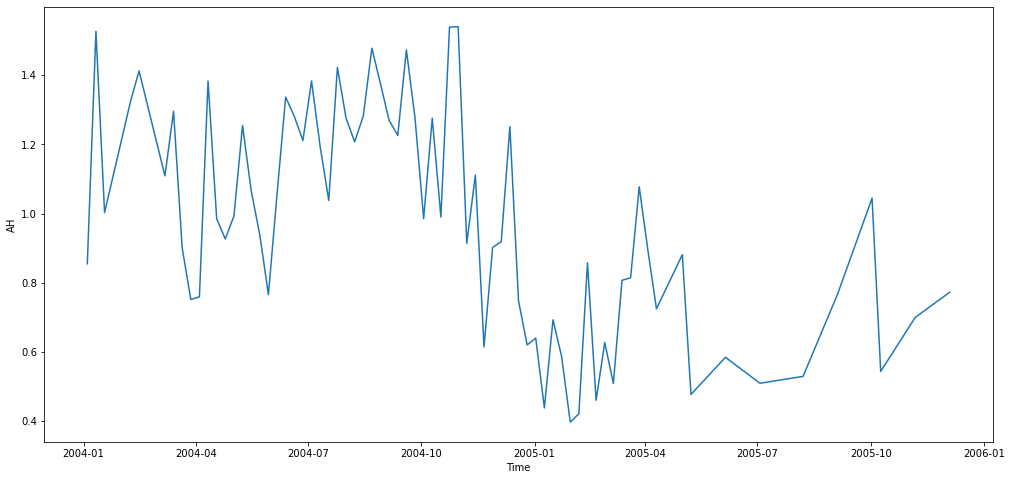

In [21]:
#plotting the trend quality of each particle by weekly.
def plot_data(col):
    plt.figure(figsize=(17, 8))
    plt.plot(weekly_data[col])
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.grid(False)
    plt.show()
    
for col in weekly_data.columns:
    plot_data(col)

## Modelling

Predicting the concentration of NOx. Oxides of nitrogen react to form smog and acid rain, as well as being central to the formation of fine particles and ground level ozone, both of which are associated with adverse health effects.

In [22]:
#dropping other columns
cols_to_drop = ['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

weekly_data = weekly_data.drop(cols_to_drop, axis=1)

In [23]:
weekly_data.head()

,PT08.S3(NOx)
Date,
2004-01-04,880.666667
2004-01-11,760.484990
2004-01-18,1490.333333
2004-02-08,869.108333
2004-02-15,706.395833


In [24]:
#importig prophet
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

Importing plotly failed. Interactive plots will not work.


In [25]:
#Prophet requires the date column to be named ds and the feature column to be named y, so we make the appropriate changes.
# Change the column names according to Prophet's guidelines
df = weekly_data.reset_index()
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2004-01-04,880.666667
1,2004-01-11,760.484990
2,2004-01-18,1490.333333
3,2004-02-08,869.108333
4,2004-02-15,706.395833


In [26]:
#splitting data
prediction_size = 30
train_df = df[:-prediction_size]

In [27]:
#fitting the model
m = Prophet()
m.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
#making forecast
future = m.make_future_dataframe(periods=prediction_size)

forecast = m.predict(future)

In [29]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2004-01-04,947.675736,796.536380,1109.408466,947.675736,947.675736,0.0,0.0,0.0,0.0,0.0,0.0,947.675736
1,2004-01-11,944.838998,783.529036,1125.090877,944.838998,944.838998,0.0,0.0,0.0,0.0,0.0,0.0,944.838998
2,2004-01-18,942.002260,777.920415,1114.814824,942.002260,942.002260,0.0,0.0,0.0,0.0,0.0,0.0,942.002260
3,2004-02-08,933.492046,769.578699,1101.042608,933.492046,933.492046,0.0,0.0,0.0,0.0,0.0,0.0,933.492046
4,2004-02-15,930.655308,770.438545,1096.729956,930.655308,930.655308,0.0,0.0,0.0,0.0,0.0,0.0,930.655308


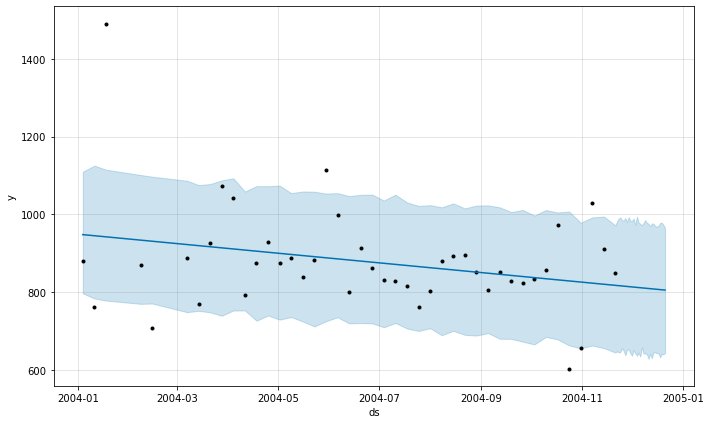

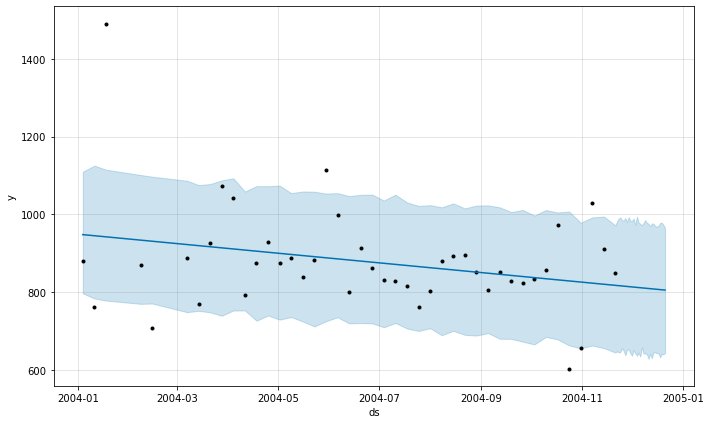

In [30]:
#forecast plots
m.plot(forecast)

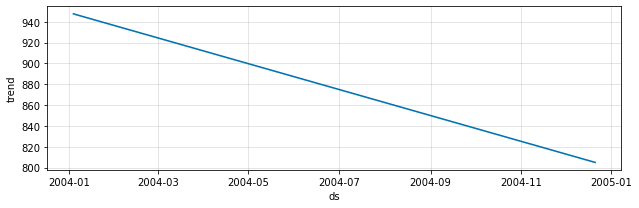

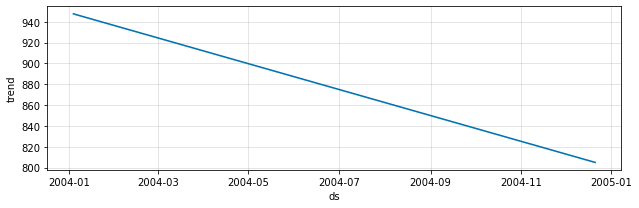

In [31]:
m.plot_components(forecast)

In [32]:
# Evaluate the model
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [33]:
cmp_df = make_comparison_dataframe(df, forecast)

cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2004-01-04,947.675736,796.536380,1109.408466,880.666667
2004-01-11,944.838998,783.529036,1125.090877,760.484990
2004-01-18,942.002260,777.920415,1114.814824,1490.333333
2004-02-08,933.492046,769.578699,1101.042608,869.108333
2004-02-15,930.655308,770.438545,1096.729956,706.395833


In [34]:
#model evaluation
def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [35]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 13.87407203410387
MAE 109.32387955182074


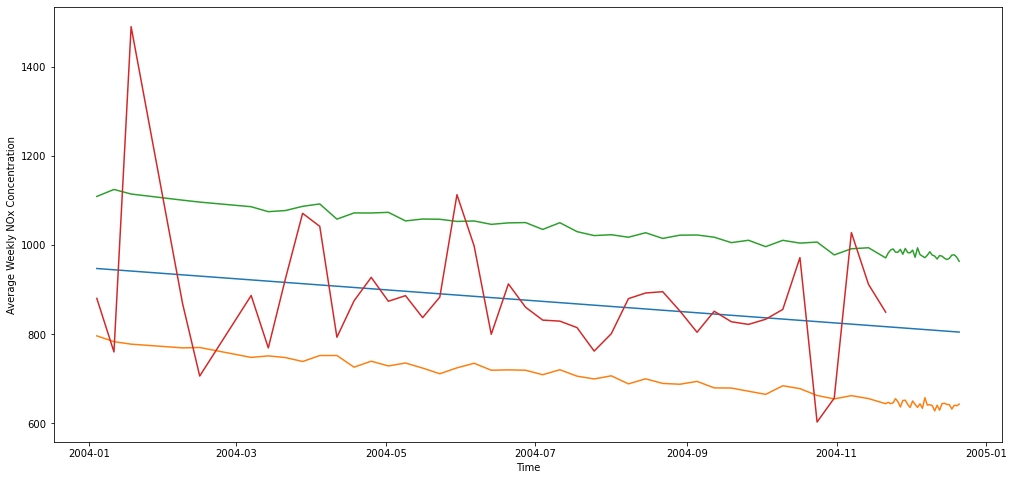

In [36]:
# Plotting forecast with upper and lower bounds
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])
plt.xlabel('Time')
plt.ylabel('Average Weekly NOx Concentration')
plt.grid(False)
plt.show()

As you can see, Prophet simply used a straight downward line to predict the concentration of NOx in the future. Prophet only identified a downward trend with no seasonality.
Evaluating the model’s performance by calculating its mean absolute percentage error (MAPE) and mean absolute error (MAE), we see that the MAPE is 13.86% and the MAE is 109.32, which is not bad. 